## Explore and clean data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statistics
import scipy
%matplotlib inline

In [4]:
gltbc = pd.read_csv("./data/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv")
gltbc.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [10]:
#Interpolating NaN - Values in AverageTemperature row
#Dropping unneccesary columns
gltbc_clean = gltbc.copy()
gltbc_clean.drop(['AverageTemperatureUncertainty'], inplace = True, axis = 1)
gltbc_clean['AverageTemperature'].interpolate(method = 'linear', inplace = True)
gltbc_clean[gltbc_clean['Country'] == 'Germany']

,dt,AverageTemperature,Country
201440,1743-11-01,5.4680,Germany
201441,1743-12-01,6.0620,Germany
201442,1744-01-01,6.6560,Germany
201443,1744-02-01,7.2500,Germany
201444,1744-03-01,7.8440,Germany
...,...,...,...
204674,2013-05-01,12.1510,Germany
204675,2013-06-01,15.9270,Germany
204676,2013-07-01,19.7620,Germany
204677,2013-08-01,18.2330,Germany


In [11]:
#Cast 'dt' colum to DateTime object
gltbc_clean['dt'] = gltbc_clean['dt'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
#Select Germany subset
gltbc_ger = gltbc_clean[gltbc['Country'] == 'Germany'].copy()

In [13]:
#Add column with saisons and years
def season(date):
    if date.month < 3 or date.month == 12:
        return "Winter"
    
    elif date.month > 2 and date.month < 6:
        return "Spring"
    
    elif date.month > 5 and date.month < 9:
        return "Summer"
    
    else:
        return 'Autumn'
    
    
gltbc_ger['Season'] = gltbc_ger['dt'].apply(season)
gltbc_ger['Year'] = gltbc_ger['dt'].apply(lambda x: x.year)

## Descriptive Statistics

1a) Highest temperature, lowest, mean, median, mad and alpha trimmed mean

In [15]:
#Calculate the max, min, mean and median
max_temp = gltbc_ger['AverageTemperature'].max()
min_temp = gltbc_ger['AverageTemperature'].min()
mean_temp = gltbc_ger['AverageTemperature'].mean()
median_temp = gltbc_ger['AverageTemperature'].median()
mad_temp = gltbc_ger['AverageTemperature'].mad()
trim_mean_temp = scipy.stats.trim_mean(gltbc_ger['AverageTemperature'], 0.1)
var_temp = gltbc_ger['AverageTemperature'].var()
std_temp = gltbc_ger['AverageTemperature'].std()


#Create DataFrame with values
data = {'Temperature in °C':map(lambda x: round(x, 2), [max_temp, min_temp, mean_temp, median_temp, mad_temp, trim_mean_temp, var_temp, std_temp])}
stats = pd.DataFrame(data, index = ['max_temp min_temp mean_temp median_temp mad_temp trim_mean_temp var_temp std_temp'.split(" ")])
stats

,Temperature in °C
max_temp,22.47
min_temp,-9.30
mean_temp,8.07
median_temp,7.86
mad_temp,6.04
trim_mean_temp,8.18
var_temp,47.33
std_temp,6.88


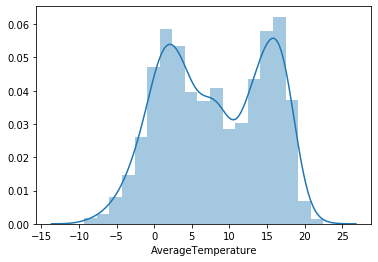

In [78]:
sns.distplot(gltbc_ger['AverageTemperature'])

b) Distribution function for seasons

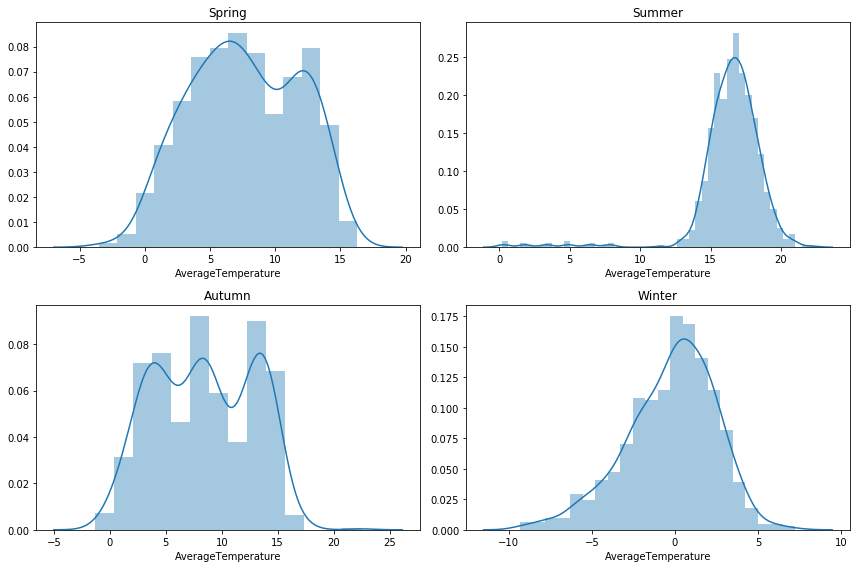

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Spring']['AverageTemperature'], ax=axs[0][0]).set_title('Spring')
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Summer']['AverageTemperature'], ax=axs[0][1]).set_title('Summer')
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Autumn']['AverageTemperature'], ax=axs[1][0]).set_title('Autumn')
sns.distplot(gltbc_ger[gltbc_ger['Season'] == 'Winter']['AverageTemperature'], ax=axs[1][1]).set_title('Winter')
plt.tight_layout()

Text(0.5, 1.0, 'Germany average Temperature 1850 - 2013')

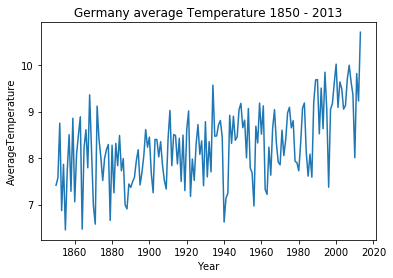

In [71]:
#Temperature over time
gltbc_ger_byyear = gltbc_ger.groupby(['Year']).mean()

fig, axes = plt.subplots()
axes.plot(gltbc_ger_byyear.loc[1850:2013]['AverageTemperature'])
axes.set_xlabel('Year')
axes.set_ylabel('AverageTemperature')
axes.set_title('Germany average Temperature 1850 - 2013')

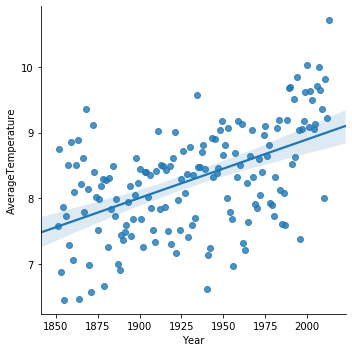

In [72]:
gltbc_ger_byyear.reset_index(level=0, inplace=True)
sns.lmplot(x = 'Year', y = 'AverageTemperature', data = gltbc_ger_byyear[gltbc_ger_byyear['Year'] > 1850])

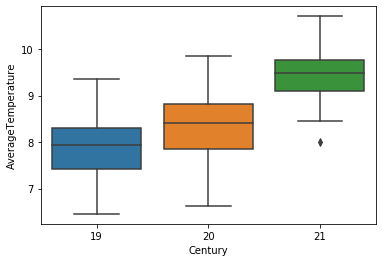

In [73]:
def century(year):
    if year < 1800:
        return 18
    
    elif year < 1900 and year > 1800:
        return 19
    
    elif year < 2000 and year > 1900:
        return 20
    
    else:
        return 21
    
gltbc_ger_byyear['Century'] = gltbc_ger_byyear['Year'].apply(century)
    
sns.boxplot(x = 'Century', y = 'AverageTemperature', data = gltbc_ger_byyear[gltbc_ger_byyear['Year'] > 1850])